In [32]:
# Imports
import pandas as pd
import numpy as np
import os
from sklearn.metrics import f1_score
import torch
from keras.preprocessing.text import Tokenizer

import torch.nn as nn
import time
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import f1_score

In [22]:
# Load data

team_id = '20' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('dataset/tweets_train.csv')
df_test = pd.read_csv(f'dataset/tweets_{split}.csv')
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

# create train and validation sets
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

In [26]:
## Tokenize the sentences
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df.words_str.values))
print('Found %d unique words.' % len(tokenizer.word_index))
train_X = tokenizer.texts_to_sequences(df_train.words_str.values)
test_X = tokenizer.texts_to_sequences(df_val.words_str.values)
print(type(train_X))
print(len(train_X))
print(train_X[1])

Found 16163 unique words.
<class 'list'>
6400
[4966, 956, 109, 2950, 135, 6, 420, 1852, 222, 407, 891, 229, 137, 1151, 117, 231, 33, 19, 3359, 2539]


In [27]:
# padding
from keras_preprocessing.sequence import pad_sequences

maxlen = None
# find max length of sentence
maxlen = max([len(s) for s in train_X])

train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [28]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(df_train.sentiment.values)
test_y = le.transform(df_val.sentiment.values)

In [8]:
def load_glove(word_index):
    # EMBEDDING_FILE = 'input/glove840b300dtxt/glove.840B.300d.txt'
    EMBEDDING_FILE = 'models/glove.twitter.27B/glove.twitter.27B.200d.txt'
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')[:200]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in   open(EMBEDDING_FILE))
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]
    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix
embedding_matrix = load_glove(tokenizer.word_index)

In [18]:
class BiLSTM(nn.Module):
    def __init__(self, max_features, embed_size, embedding_matrix, n_classes, hidden_size=64, drp=0.1):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)
    def forward(self, x):
        #rint(x.size())*
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))*
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out


In [38]:
n_epochs = 40
batch_size = 32
embed_size = 200
hidden_size = 64
dropout = 0.3
num_classes = 3
learning_rate = 1e-4
model = BiLSTM(max_features=max_features, embed_size=embed_size, hidden_size=hidden_size, drp=dropout, n_classes=num_classes, embedding_matrix=embedding_matrix)
# loss_fn = nn.CrossEntropyLoss(reduction='sum')
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
model.cuda()
# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()
# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)
# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
train_loss = []
valid_loss = []
training_f1 = []
validation_f1 = []
for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    train_predictions, train_true_labels = [], []  # Store predictions and true labels for F1 score
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        # Get predictions for F1 score calculation
        _, preds = torch.max(y_pred, 1)
        train_predictions.extend(preds.cpu().numpy())
        train_true_labels.extend(y_batch.cpu().numpy())
    avg_loss = avg_loss / len(train_loader)

    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    val_predictions, val_true_labels = [], []  # Store predictions and true labels for F1 score
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(valid_loader):
            y_pred = model(x_batch).detach()
            # avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            # keep/store predictions
            # val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
            loss_val = loss_fn(y_pred, y_batch)
            avg_val_loss += loss_val.item()
            # Get predictions for F1 score calculation
            _, preds = torch.max(y_pred, 1)
            val_predictions.extend(preds.cpu().numpy())
            val_true_labels.extend(y_batch.cpu().numpy())
    avg_val_loss = avg_val_loss / len(valid_loader)

    # Check Accuracy
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)

    # Calculate F1 macro scores
    train_f1 = f1_score(train_true_labels, train_predictions, average='macro')
    val_f1 = f1_score(val_true_labels, val_predictions, average='macro')
    training_f1.append(train_f1)
    validation_f1.append(val_f1)

    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t f1={:.4f} \t val_loss={:.4f}  \t val_f1={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, train_f1, avg_val_loss, val_f1, elapsed_time))

Epoch 1/40 	 loss=0.8645 	 f1=0.2677 	 val_loss=0.7677  	 val_f1=0.2701  	 time=1.08s
Epoch 2/40 	 loss=0.7984 	 f1=0.2710 	 val_loss=0.7370  	 val_f1=0.2701  	 time=0.99s
Epoch 3/40 	 loss=0.7528 	 f1=0.3496 	 val_loss=0.6707  	 val_f1=0.3708  	 time=1.02s
Epoch 4/40 	 loss=0.6795 	 f1=0.4606 	 val_loss=0.6350  	 val_f1=0.4812  	 time=1.04s
Epoch 5/40 	 loss=0.6384 	 f1=0.4834 	 val_loss=0.6006  	 val_f1=0.4903  	 time=0.98s
Epoch 6/40 	 loss=0.6118 	 f1=0.5000 	 val_loss=0.5875  	 val_f1=0.4879  	 time=1.00s
Epoch 7/40 	 loss=0.5933 	 f1=0.5048 	 val_loss=0.5745  	 val_f1=0.4902  	 time=0.96s
Epoch 8/40 	 loss=0.5801 	 f1=0.5004 	 val_loss=0.5618  	 val_f1=0.5009  	 time=0.96s
Epoch 9/40 	 loss=0.5605 	 f1=0.5115 	 val_loss=0.5633  	 val_f1=0.5050  	 time=1.02s
Epoch 10/40 	 loss=0.5460 	 f1=0.5178 	 val_loss=0.5491  	 val_f1=0.5009  	 time=0.98s
Epoch 11/40 	 loss=0.5357 	 f1=0.5183 	 val_loss=0.5421  	 val_f1=0.5028  	 time=0.99s
Epoch 12/40 	 loss=0.5263 	 f1=0.5232 	 val_loss=0.5

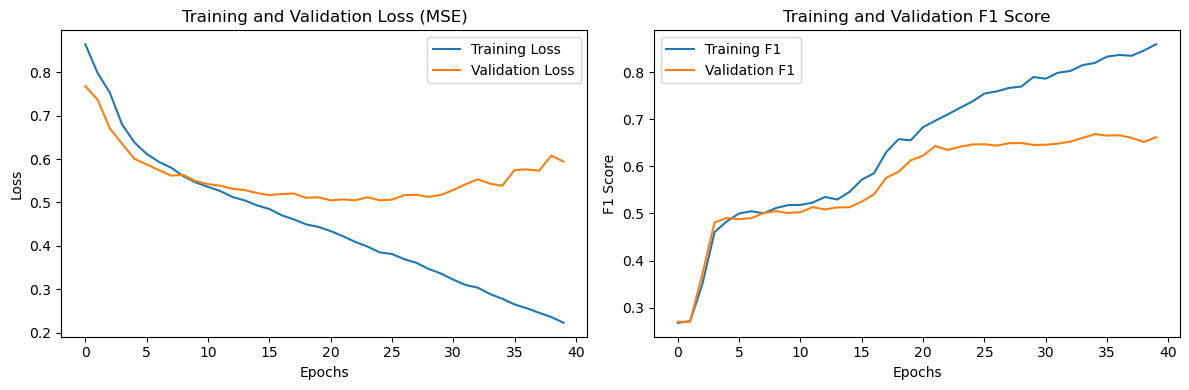

In [39]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Loss (MSE)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation RMSE
plt.subplot(1, 2, 2)
plt.plot(training_f1, label='Training F1')
plt.plot(validation_f1, label='Validation F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()